# Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
#from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier

from math import ceil

In [2]:
leads = pd.read_csv('leads_cleaned_2.csv', index_col=0)

In [3]:
print(leads.dtypes)
leads.head()

lead_number          int64
origin              object
source              object
no_email             int64
converted            int64
visits             float64
visit_time           int64
visit_pages        float64
last_activity       object
country             object
specialization      object
hear_about          object
occupation          object
search               int64
recommendations      int64
quality             object
profile             object
city                object
activity_index       int64
profile_index        int64
mti_copy             int64
modified             int64
dtype: object


,lead_number,origin,source,no_email,converted,visits,visit_time,visit_pages,last_activity,country,...,occupation,search,recommendations,quality,profile,city,activity_index,profile_index,mti_copy,modified
0,660737,API,Olark Chat,0,0,0.0,0,0.0,Page Visited on Website,Unknown,...,Unemployed,0,0,Low in Relevance,Unknown,Unknown,2,2,0,1
1,660728,API,Organic Search,0,0,5.0,674,2.5,Email Opened,India,...,Unemployed,0,0,Unknown,Unknown,Unknown,2,2,0,0
2,660727,Landing Page Submission,Direct Traffic,0,1,2.0,1532,2.0,Email Opened,India,...,Student,0,0,Might be,Potential Lead,Mumbai,2,3,1,0
3,660719,Landing Page Submission,Direct Traffic,0,0,1.0,305,1.0,Unreachable,India,...,Unemployed,0,0,Not Sure,Unknown,Mumbai,2,2,0,1
4,660681,Landing Page Submission,Google,0,1,2.0,1428,1.0,Converted to Lead,India,...,Unemployed,0,0,Might be,Unknown,Mumbai,2,3,0,1


### Encoding Categorical Variables
Our dataset includes 10 categorical variables that still need to be encoded. These are all nominal categories (our two ordinal categories have already been encoded), and can be handled with One Hot Encoding. However, some of these categories (such as country and source) have rather high cardinality, so it may be useful later to see if combining some of the low-count values improves our model.

In [4]:
# Checking the cardinality of categorical variables. For now, we will leave them as-is.
leads.select_dtypes(include=['object']).nunique()

origin             5
source            21
last_activity     18
country           39
specialization    19
hear_about        10
occupation         7
quality            6
profile            6
city               7
dtype: int64

In [5]:
leads = pd.get_dummies(leads)
leads.shape

(9240, 150)

In [6]:
# We can delete the 'Unknown' columns, as a 0 in all other columns already contains that information.
for col in leads.columns:
    if 'Unknown' in col:
        leads.drop(col, axis=1, inplace=True)

leads.shape

(9240, 141)

In [7]:
# To begin modeling, we'll separate our dependent variable y, and remove the lead_number column (we don't want this id
# column to influence our model, since any possible correlation with this dataset won't help us with future predictions).
y = leads.converted
X = leads.drop(['converted', 'lead_number'], axis=1)

# PCA
Before we begin, we can check whether our data can be simplified through dimension reduction. If we can reduce the dimensionality of our data, it could make distance-based models more effective.

In [8]:
# First we must scale the data to standardize variance of each feature.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

<AxesSubplot:xlabel='1', ylabel='2'>

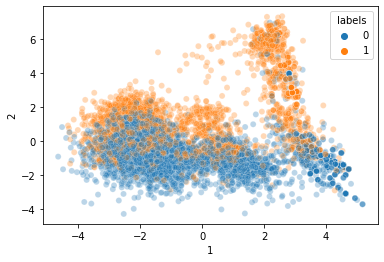

In [9]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=[str(n+1) for n in range(139)])
pca_df['labels'] = y

sns.scatterplot(data=pca_df, x='1', y='2', hue='labels', alpha=0.3)

It looks like there is some significance to the second principal component (on the y axis) in relation to the dependent variable

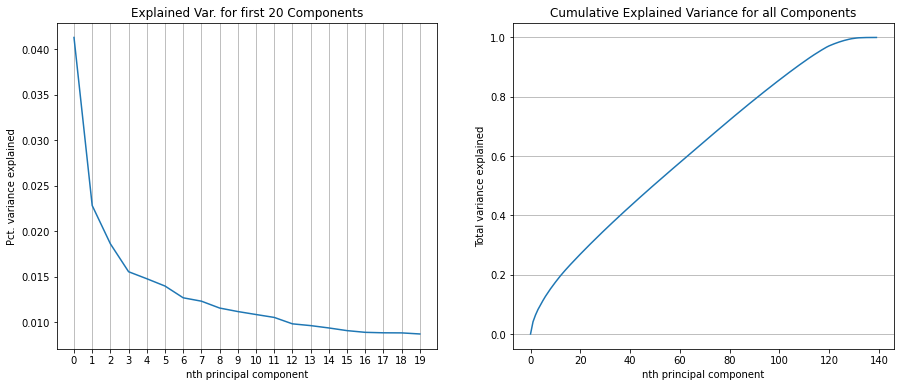

In [10]:
# Let's look at the first 20 components and plot the explained variance
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(range(20), pca.explained_variance_ratio_[:20])
plt.title('Explained Var. for first 20 Components')
plt.xlabel('nth principal component')
plt.ylabel('Pct. variance explained')
plt.xticks(range(0, 20, 1))
plt.grid(axis='x')

# And now to see the cumulative explained variance over all components
ev_cumulative = [0]
for i, ev in enumerate(pca.explained_variance_ratio_):
    ev_cumulative.append(ev_cumulative[i] + ev)

plt.subplot(1, 2, 2)
plt.plot(range(len(ev_cumulative)), ev_cumulative)
plt.title('Cumulative Explained Variance for all Components')
plt.xlabel('nth principal component')
plt.ylabel('Total variance explained')
plt.grid(axis='y')
plt.show()

Judging from these graphs, although the gain in variance explained does begin to level off after the fourth component, those components still only account for less than 15% of the variance. In order not to lose too much information from the data, we shouldn't reduce the dimensionality that much.

Furthermore, by not using PCA to reduce the dimensions of our data, we are able to maintain a strong interpretability of our results. This will help towards one of the main goals of this project, which is to identify specific features that the marketing team can target in order to achieve greater quality of leads overall.

# Logistic Regression

The goal of this project is to be able to assign a score of likelihood of conversion for each new lead, based on the information collected. To do this, we will try a few different models to see which gives us the best predictive capabilities.

In [11]:
# Split our dataset into train and test data (80/20), and scale the X vectors
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Check n for train and test sets, and percent of target variable
len_tr, len_te = len(y_train), len(y_test)
pct_tr, pct_te = y_train.sum()/len_tr*100, y_test.sum()/len_te*100
print("Training Set: {} samples, {}% converted\nTest Set: {} samples, {}% converted".format(len_tr,
                                                                                            int(round(pct_tr)),
                                                                                            len_te,
                                                                                            int(round(pct_te))))

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Training Set: 7392 samples, 39% converted
Test Set: 1848 samples, 38% converted


In [12]:
# Instantiate a basic LogReg Classifier
logreg = LogisticRegression(max_iter=200)

In [13]:
# Find the best value for the regularization parameter C, optimizing log loss in order to emphasize accurate probabilities
# (I've run this cell a few times to find the best range of values to test) 

c_dict = {'C':np.arange(0.01, 0.11, 0.01)}
cv = GridSearchCV(logreg, c_dict, scoring='neg_log_loss', n_jobs=-1)
cv.fit(X_train, y_train)
print(cv.best_params_, cv.best_score_)

{'C': 0.03} -0.3367822491414745


In [52]:
# Instantiate the model with the best C and fit to train data
lr_model = LogisticRegression(C=0.03, max_iter=200)
lr_model.fit(X_train, y_train)

LogisticRegression(C=0.03, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [104]:
def plot_roc(clf, X=X_test, y=y_test):
    '''Calculate and plot ROC curve with AUC annotation'''
    pred_prob = clf.predict_proba(X)[:,1]
    auc = round(roc_auc_score(y, pred_prob),3)
    fpr, tpr, thresholds = roc_curve(y, pred_prob)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.annotate('AUC = '+str(auc), (0.2,0.6))
    plt.show()

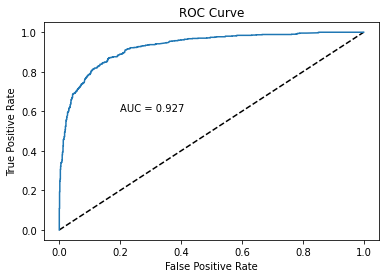

In [105]:
plot_roc(lr_model)

In [54]:
y_pred = lr_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      1146
           1       0.84      0.78      0.81       702

    accuracy                           0.86      1848
   macro avg       0.85      0.84      0.85      1848
weighted avg       0.86      0.86      0.86      1848



Here we see a nice ROC curve with high AUC, showing that our model can simultaneously achieve high True Positive rate with a reasonably low False Positive rate.

In practice, we would rather spend time on a lead that does not convert than ignore a lead that could possibly convert. So, we should be willing to accept some False Positives if it means we won't miss any possible conversions. In other words, we want our model to have a high recall for positive cases. In the above classification report, we see our model had a recall for the positive case of about 78%.

If we were using this model simply to label new leads as converting or not converting, we would want to use a lower threshold (below 50%) in order to increase recall. However, in lead scoring we are going deeper, using the predicted probabilities to assign each new lead a *likelihood* of conversion. Therefore we are not very concerned about the threshold, but whether the predicted probabilities will map to actual conversion rates for new leads.

To get a sense of how well our model does this, we will group leads with a similar probability of conversion into 10 bins (score 1-10) to indicate the strength of each lead. Then, we can calculate the actual rate of conversion for leads in each bin.

We expect the lead score to roughly correspond to the probability of conversion (that is, a score of 5/10 means 50% chance of success). 

In [100]:
def print_conversion_rates(clf, X=X_test, y=y_test, bin_func=ceil):
    '''Uses given classifier to assign lead score based on predicted probabilities, and 
    compares to actual conversion rates'''
    
    pred_prob = clf.predict_proba(X)[:,1]
    scores = [int(bin_func(p * 10)) for p in pred_prob]
    score_df = pd.DataFrame({'converted':y, 'lead_score':scores}, index=y.index)
    
    for score in set(scores):
        group = score_df[score_df.lead_score==score]
        group_size = len(group)
        n_converted = group.converted.sum()
        conversion_rate = n_converted/group_size
        print("Lead Score {}: {}% conversion in test set ({} out of {})".format(score, 
                                                                         round(conversion_rate*100,1), 
                                                                         n_converted,
                                                                         group_size))

In [102]:
print_conversion_rates(lr_model)

Lead Score 1: 3.3% conversion in test set (22 out of 665)
Lead Score 2: 13.0% conversion in test set (32 out of 246)
Lead Score 3: 27.5% conversion in test set (39 out of 142)
Lead Score 4: 41.0% conversion in test set (34 out of 83)
Lead Score 5: 48.3% conversion in test set (29 out of 60)
Lead Score 6: 57.0% conversion in test set (45 out of 79)
Lead Score 7: 56.6% conversion in test set (30 out of 53)
Lead Score 8: 78.0% conversion in test set (64 out of 82)
Lead Score 9: 86.0% conversion in test set (98 out of 114)
Lead Score 10: 95.4% conversion in test set (309 out of 324)


The observed conversion rates above show that the score is lower than expected for groups 1 and 2. This might be acceptable, or even preferred since we would tend to disregard low-scoring leads either way (and if the conversion rate for 1s was actually 10%, we would be missing out on more sales).

In the test set, leads scoring 7 actually had a slightly lower conversion rate than 6s. This is not ideal, but errors like this are inevitable with small sample sizes (the 7s were the smallest group, with only 53 leads in the test set). It is a good reminder that no scoring system will be 100% accurate, and sales staff should be using the score as a guideline, not an absolute truth.

Finally, before moving on, let's look at the coefficients of the model to see which features were most important.

In [103]:
# Construct df of features with associated coefficient and rank (will add to later with other models)
coefs = lr_model.coef_[0]

feature_df = pd.DataFrame({'feature':X.columns, 'lr_coef_dir':coefs>=0, 'lr_coef':abs(coefs)})
feature_df.lr_coef_dir.replace({True:'+', False:'-'}, inplace=True)
feature_df.sort_values('lr_coef', ascending=False, inplace=True)
feature_df['lr_rank'] = range(1, len(X.columns)+1)

feature_df.head(10)

,feature,lr_coef_dir,lr_coef,lr_rank
2,visit_time,+,1.003319,1
123,quality_High in Relevance,+,0.718234,2
122,occupation_Working Professional,+,0.576858,3
47,last_activity_SMS Sent,+,0.567486,4
127,quality_Worst,-,0.553964,5
125,quality_Might be,+,0.483375,6
124,quality_Low in Relevance,+,0.447189,7
29,source_Welingak Website,+,0.379703,8
44,last_activity_Olark Chat Conversation,-,0.355449,9
9,modified,-,0.336596,10


We see the most important feature by far is visit_time, followed by leads marked as high-quality.

The 'quality' field appears several times in these top features, which makes sense. Recall that quality was defined as "the quality of lead based on the data and intuition the the employee who has been assigned to the lead." This column, then, is itself a subjective lead score given by sales staff.

The information from this column is clearly important to our model, and we don't want to lose it. However, it should be noted that this may be a problem if we want to use our model for fair distribution in assigning leads - we won't have this information until after the lead is assigned! Instead, I suggest either (a) Have staff quickly give a first impression of quality for all new leads before scoring and assigning the lead, or (b) distribute leads randomly, then score and redistribute leads once this category can be filled.

# Random Forest
Next, we'll try a Random Forest model and see if we can improve our scoring system.

In [22]:
'''
leads = leads.drop('lead_number', axis=1)
low_coefs = list(feature_df[feature_df.lr_coef < 0.03].feature)
leads2 = leads.drop(low_coefs, axis=1)
print(leads2.shape)

X2 = leads2.drop('converted', axis=1)
y2 = leads2.converted
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2)
'''

(9240, 140)

In [36]:
rf_model = RandomForestClassifier(random_state=123)

In [90]:
# Find the best value for hyperparameters (using RandomizedSearchCV for time efficiency)
param_dict = {'n_estimators':np.arange(50, 550, 50),
              'max_depth':np.arange(5, 35, 5),
              'max_features':np.arange(10, 55, 5)}

cv_rand = RandomizedSearchCV(rf_model, param_dict, scoring='neg_log_loss', n_jobs=-1, random_state=123)
cv_rand.fit(X_train, y_train)
cv_rand.best_params_, cv_rand.best_score_

({'n_estimators': 400, 'max_features': 20, 'max_depth': 20},
 -0.32162167562732297)

In [92]:
rf_model = RandomForestClassifier(max_depth=20, max_features=20, n_estimators=400, random_state=123)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features=20,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

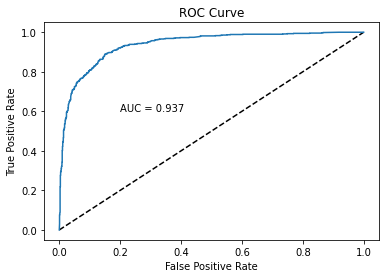

In [106]:
plot_roc(rf_model)

In [93]:
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      1146
           1       0.85      0.78      0.81       702

    accuracy                           0.86      1848
   macro avg       0.86      0.85      0.85      1848
weighted avg       0.86      0.86      0.86      1848



In [107]:
print_conversion_rates(rf_model)

Lead Score 1: 2.8% conversion in test set (20 out of 721)
Lead Score 2: 12.2% conversion in test set (20 out of 164)
Lead Score 3: 20.3% conversion in test set (24 out of 118)
Lead Score 4: 42.5% conversion in test set (48 out of 113)
Lead Score 5: 48.1% conversion in test set (39 out of 81)
Lead Score 6: 46.2% conversion in test set (30 out of 65)
Lead Score 7: 72.8% conversion in test set (59 out of 81)
Lead Score 8: 78.6% conversion in test set (77 out of 98)
Lead Score 9: 90.4% conversion in test set (104 out of 115)
Lead Score 10: 96.2% conversion in test set (281 out of 292)


The f1 scores for this Random Forest model are the same as for the LogReg model, although ROC-AUC is a bit higher for the RF model.

Looking at the actual conversion rates for each lead score group, again the low-scoring leads have even lower than expected conversion. For this model, the 6s had a strange outcome, with lower conversion than the 5s. Otherwise, the other lead scores are pretty close to what we would expect. 

Of course, we must remember these percentages are subject to variation due to sample size, but we would ideally like to find a model that can produce more reliable results.

# XGBoost

In [108]:
import xgboost as xgb

ModuleNotFoundError: No module named 'xgboost'